# MERSCOPE Region R3 Analysis

In [1]:
# Import necessary libraries
import sys
import os
import scanpy as sc
import anndata as ad
import pandas as pd
import geopandas as gpd # For potential .parquet file with geometries
import matplotlib.pyplot as plt
import matplotlib.image as mpimg # For displaying images
import seaborn as sns
import numpy as np # For calculations if needed
import squidpy
import warnings
from shapely import wkt

# Add the project root to the Python path
# script_dir = os.path.dirname(__file__)
script_dir = "E:/Githubs/SPATIAL_data/p30"
project_root = os.path.abspath(os.path.join(script_dir, '..'))
sys.path.append(project_root)

from helpers.plotting import create_volcano_plot

# Suppress FutureWarning messages
warnings.filterwarnings('ignore', category=FutureWarning)

# Set plotting style
# plt.style.use('seaborn-v0_8-whitegrid')
# sc.settings.set_figure_params(dpi=100, frameon=True, figsize=(6, 6), facecolor='white')

In [2]:
# Custom volcano plot for scanpy differential gene expression results
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

In [3]:
# Define file paths
base_path = '../202503071102_SESSA-p30-E165_VMSC10702/R3'
h5ad_file = os.path.join(base_path, '202503071102_SESSA-p30-E165_VMSC10702_region_R3.h5ad')
roi_csv_file_name = 'p30_R3_ROI_28-05-25_16-57_geometry.csv'
roi_geometry_file_path = os.path.join(base_path, roi_csv_file_name)
summary_image_file = os.path.join(base_path, 'summary.png')
plot_enable = True

## 1. Data Loading

In [4]:
# Load the .h5ad file
adata = sc.read_h5ad(h5ad_file)

In [5]:
keep_genes = [x for x in adata.var.index.tolist() if 'Blank' not in x]
print(len(keep_genes))
print(adata.shape[1])

960
960


In [6]:
min_expression = 25
ser_exp = adata.to_df().sum(axis=1)

keep_cells = ser_exp[ser_exp > min_expression].index.tolist()
print(len(keep_cells))
print(adata.shape[0])

# adata = adata[keep_cells]
# adata

43283
43284


In [7]:
# Cell boundaries
cell_boundaries_file = os.path.join(base_path, 'cell_boundaries.parquet')
cell_boundaries_gdf = None

In [8]:
cell_boundaries_gdf = gpd.read_parquet(cell_boundaries_file)
print(f"Loaded {cell_boundaries_file}. Shape: {cell_boundaries_gdf.shape}")

Loaded ../202503071102_SESSA-p30-E165_VMSC10702/R3\cell_boundaries.parquet. Shape: (308336, 9)


In [9]:
cell_boundaries_gdf.head()

,ID,EntityID,ZIndex,Geometry,ParentType,ParentID,Type,ZLevel,Name
221,221,1678497900003100071,3,"MULTIPOLYGON (((1718.352 6632.353, 1719.325 66...",None,None,cell,6.0,None
227,227,1678497900003100081,3,"MULTIPOLYGON (((1714.804 6647.359, 1714.69 664...",None,None,cell,6.0,None
249,249,1678497900003100109,3,"MULTIPOLYGON (((1834.034 6686.586, 1834.384 66...",None,None,cell,6.0,None
256,256,1678497900003100119,3,"MULTIPOLYGON (((1796.273 6691.157, 1796.019 66...",None,None,cell,6.0,None
266,266,1678497900003100131,3,"MULTIPOLYGON (((1669.81 6716.083, 1670.572 671...",None,None,cell,6.0,None


In [10]:
cell_boundaries_gdf = cell_boundaries_gdf.set_index('EntityID', drop=False)
cell_boundaries_gdf.head()

,ID,EntityID,ZIndex,Geometry,ParentType,ParentID,Type,ZLevel,Name
EntityID,,,,,,,,,
1678497900003100071,221,1678497900003100071,3,"MULTIPOLYGON (((1718.352 6632.353, 1719.325 66...",None,None,cell,6.0,None
1678497900003100081,227,1678497900003100081,3,"MULTIPOLYGON (((1714.804 6647.359, 1714.69 664...",None,None,cell,6.0,None
1678497900003100109,249,1678497900003100109,3,"MULTIPOLYGON (((1834.034 6686.586, 1834.384 66...",None,None,cell,6.0,None
1678497900003100119,256,1678497900003100119,3,"MULTIPOLYGON (((1796.273 6691.157, 1796.019 66...",None,None,cell,6.0,None
1678497900003100131,266,1678497900003100131,3,"MULTIPOLYGON (((1669.81 6716.083, 1670.572 671...",None,None,cell,6.0,None


# Subselect cells based on ROI polygons from CSV

This section loads ROI polygons from a CSV file, converts them to geometries,
and then selects cells from `cell_boundaries_gdf` that fall within these ROIs.

In [11]:
# Load ROI geometry data from CSV
roi_polygons_df = pd.read_csv(roi_geometry_file_path)
print(f"Successfully loaded ROI geometry file: {roi_geometry_file_path}")
print("ROI CSV Head:")
print(roi_polygons_df.head())

Successfully loaded ROI geometry file: ../202503071102_SESSA-p30-E165_VMSC10702/R3\p30_R3_ROI_28-05-25_16-57_geometry.csv
ROI CSV Head:
      EntityID                                           geometry  \
0  hippocampus  POLYGON ((2648.78 8157.38, 2715.3 8114.14, 279...   
1       cortex  POLYGON ((1364.97 7119.69, 1883.82 6850.28, 26...   

                                          dataset          group  
0  202503071102_SESSA-p30-E165_VMSC10702_region_2   SubROI hippo  
1  202503071102_SESSA-p30-E165_VMSC10702_region_2  SubROI cortex  


In [12]:
# Process ROI geometries and perform spatial selection

In [13]:
# Convert WKT string geometries to Shapely geometry objects
roi_polygons_df['geometry'] = roi_polygons_df['geometry'].apply(wkt.loads)

# Create a GeoDataFrame from the ROI data
# Assume cell_boundaries_gdf is already defined and has a CRS.
# If cell_boundaries_gdf.crs is None, roi_gdf.crs will also be None,
# which is acceptable if coordinates are in the same arbitrary Cartesian system.
current_crs = None
if 'cell_boundaries_gdf' in locals() and cell_boundaries_gdf is not None and hasattr(cell_boundaries_gdf, 'crs'):
    current_crs = cell_boundaries_gdf.crs
    print(f"Using CRS from cell_boundaries_gdf: {current_crs}")
else:
    print("Warning: cell_boundaries_gdf not found or has no CRS. Assuming planar coordinates for ROIs.")

Using CRS from cell_boundaries_gdf: None


In [14]:
roi_gdf = gpd.GeoDataFrame(roi_polygons_df, geometry='geometry', crs=current_crs)
print("Successfully converted ROI geometries to GeoDataFrame.")
print("ROI GeoDataFrame Head:")
roi_gdf.head()

Successfully converted ROI geometries to GeoDataFrame.
ROI GeoDataFrame Head:


,EntityID,geometry,dataset,group
0,hippocampus,"POLYGON ((2648.78 8157.38, 2715.3 8114.14, 279...",202503071102_SESSA-p30-E165_VMSC10702_region_2,SubROI hippo
1,cortex,"POLYGON ((1364.97 7119.69, 1883.82 6850.28, 26...",202503071102_SESSA-p30-E165_VMSC10702_region_2,SubROI cortex


In [15]:
# Perform spatial selection of cells within ROIs
print(f"Shape of cell_boundaries_gdf before spatial join: {cell_boundaries_gdf.shape}")
print(f"Shape of roi_gdf before spatial join: {roi_gdf.shape}")

Shape of cell_boundaries_gdf before spatial join: (308336, 9)
Shape of roi_gdf before spatial join: (2, 4)


In [16]:
# Prepare the left GeoDataFrame for sjoin to avoid 'EntityID' column clash
# The original cell_boundaries_gdf has 'EntityID' as both index and column.
# Renaming the index ensures that when sjoin (or its internal functions)
# calls reset_index(), the new column from the index doesn't conflict.
cell_boundaries_gdf_sjoin_ready = cell_boundaries_gdf.copy()
cell_boundaries_gdf_sjoin_ready.index.name = 'original_cell_EntityID_idx' # Rename the index

In [17]:
# Spatial join: find cells whose geometries are 'within' the ROI polygons
# 'how="inner"' means only cells that are within an ROI are kept.
# 'predicate="within"' checks if cell geometry is entirely within ROI geometry.
# Added lsuffix and rsuffix to handle any potential column name overlaps clearly.
cells_in_rois_gdf = gpd.sjoin(
    cell_boundaries_gdf_sjoin_ready,
    roi_gdf,
    how="inner",
    predicate="within",
    lsuffix='_cell',
    rsuffix='_roi'
)

In [18]:
cells_in_rois_gdf.head()

,ID,EntityID__cell,ZIndex,Geometry,ParentType,ParentID,Type,ZLevel,Name,index__roi,EntityID__roi,dataset,group
original_cell_EntityID_idx,,,,,,,,,,,,,
1678497900012100129,9178,1678497900012100129,3,"MULTIPOLYGON (((1531.207 7051.313, 1531.37 705...",None,None,cell,6.0,None,1,cortex,202503071102_SESSA-p30-E165_VMSC10702_region_2,SubROI cortex
1678497900012100136,9184,1678497900012100136,3,"MULTIPOLYGON (((1522.577 7061.118, 1524.067 70...",None,None,cell,6.0,None,1,cortex,202503071102_SESSA-p30-E165_VMSC10702_region_2,SubROI cortex
1678497900012100137,9185,1678497900012100137,3,"MULTIPOLYGON (((1550.644 7063.59, 1551.077 706...",None,None,cell,6.0,None,1,cortex,202503071102_SESSA-p30-E165_VMSC10702_region_2,SubROI cortex
1678497900012100138,9186,1678497900012100138,3,"MULTIPOLYGON (((1513.811 7064.772, 1513.859 70...",None,None,cell,6.0,None,1,cortex,202503071102_SESSA-p30-E165_VMSC10702_region_2,SubROI cortex
1678497900012100139,9187,1678497900012100139,3,"MULTIPOLYGON (((1532.595 7069.576, 1534.54 707...",None,None,cell,6.0,None,1,cortex,202503071102_SESSA-p30-E165_VMSC10702_region_2,SubROI cortex


In [19]:
print(f"\nFound {cells_in_rois_gdf.shape[0]} cells within the defined ROIs.")


Found 43911 cells within the defined ROIs.


In [20]:
print("Head of cells_in_rois_gdf (cells spatially selected by ROIs):")
print(cells_in_rois_gdf.head())

Head of cells_in_rois_gdf (cells spatially selected by ROIs):
                              ID       EntityID__cell  ZIndex  \
original_cell_EntityID_idx                                      
1678497900012100129         9178  1678497900012100129       3   
1678497900012100136         9184  1678497900012100136       3   
1678497900012100137         9185  1678497900012100137       3   
1678497900012100138         9186  1678497900012100138       3   
1678497900012100139         9187  1678497900012100139       3   

                                                                     Geometry  \
original_cell_EntityID_idx                                                      
1678497900012100129         MULTIPOLYGON (((1531.207 7051.313, 1531.37 705...   
1678497900012100136         MULTIPOLYGON (((1522.577 7061.118, 1524.067 70...   
1678497900012100137         MULTIPOLYGON (((1550.644 7063.59, 1551.077 706...   
1678497900012100138         MULTIPOLYGON (((1513.811 7064.772, 1513.859 70...

In [21]:
# Analyze the selected cells
print("\nCell counts per ROI:")
print(cells_in_rois_gdf.groupby('group').size())


Cell counts per ROI:
group
SubROI cortex    15281
SubROI hippo     28630
dtype: int64



Cell counts per ROI group (from 'group' column of ROI CSV):
group
SubROI cortex    15281
SubROI hippo     28630
dtype: int64

Plotting selected cells and ROIs...


C:\Users\janku\AppData\Local\Temp\ipykernel_57452\2052724004.py:26: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  handles, labels = ax.get_legend_handles_labels()


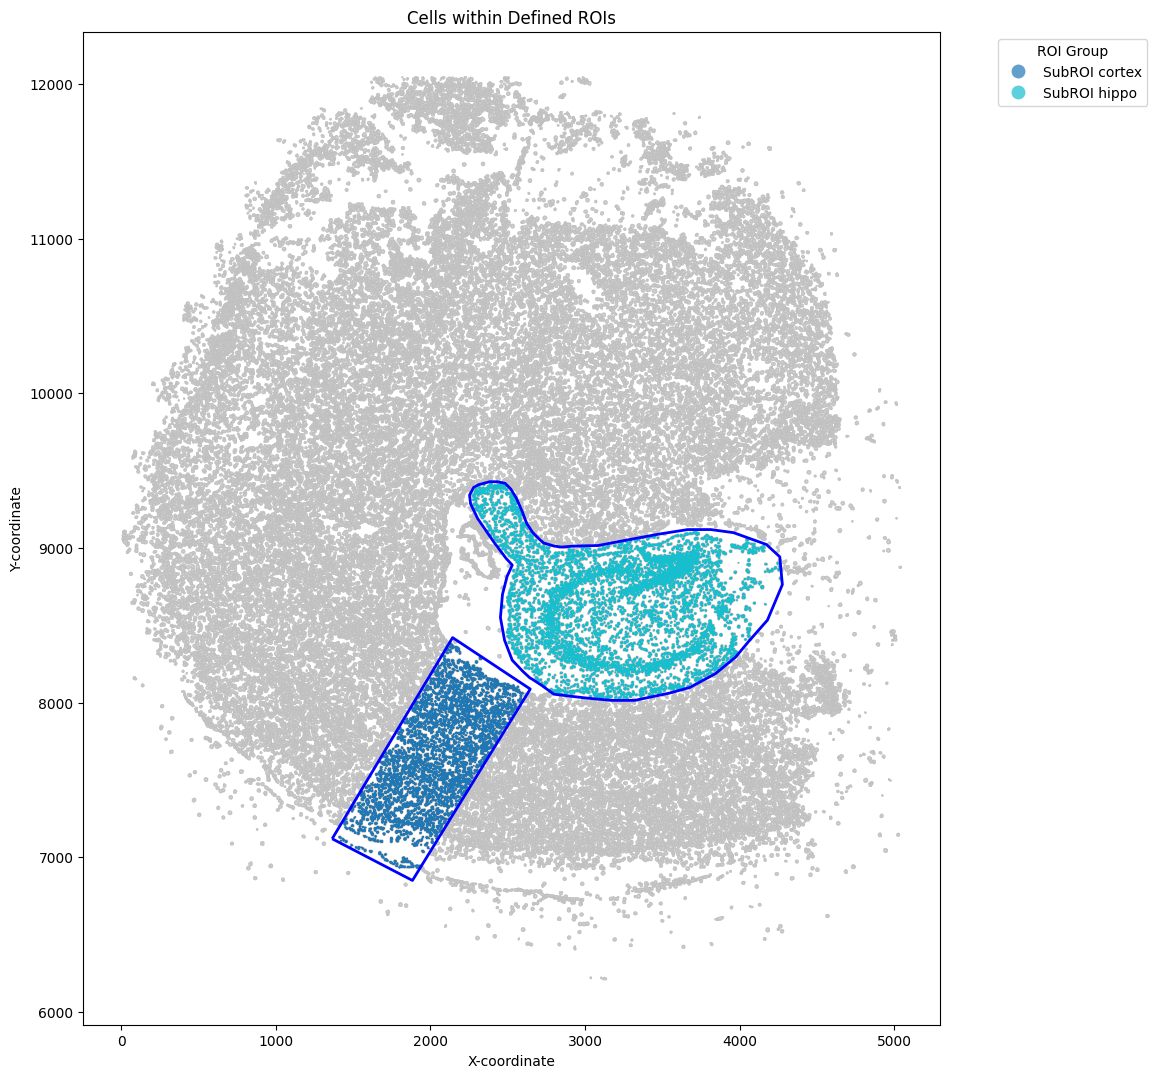

In [22]:
# Visualize selected cells with ROIs

if plot_enable:

    print("\nCell counts per ROI group (from 'group' column of ROI CSV):")
    print(cells_in_rois_gdf.groupby('group').size())

    print("\nPlotting selected cells and ROIs...")
    fig, ax = plt.subplots(1, 1, figsize=(12, 12))

    # Plot all original cell boundaries lightly
    cell_boundaries_gdf.plot(ax=ax, color='lightgray', edgecolor='silver', alpha=0.3, label='All Cells (Original)')

    unique_groups = cells_in_rois_gdf['group'].nunique()
    cells_in_rois_gdf.plot(ax=ax, column='group', legend=True, alpha=0.7, categorical=True,
                                           legend_kwds={'title': "ROI Group", 'loc': 'upper right', 'bbox_to_anchor': (1.25, 1)})

    # Plot ROI boundaries
    roi_gdf.plot(ax=ax, facecolor='none', edgecolor='blue', linewidth=2, label='ROI Polygons')

    ax.set_title("Cells within Defined ROIs")
    ax.set_xlabel("X-coordinate")
    ax.set_ylabel("Y-coordinate")

    # Adjust legend display
    handles, labels = ax.get_legend_handles_labels()

    plt.tight_layout(rect=[0, 0, 0.85, 1])
    plt.show()

# Differential Gene Expression (DGE) Analysis between ROIs

This section performs differential gene expression analysis between two selected ROIs.
It assumes that `adata` (the AnnData object with gene expression) and
`cells_in_rois_gdf` (GeoDataFrame with cells selected by ROIs and their group assignments)
are available from the previous steps.

In [23]:
# DGE Analysis
print("\nStarting Differential Gene Expression Analysis...")
roi_group_column = 'group'

# Get unique ROI groups
available_roi_groups = cells_in_rois_gdf[roi_group_column].unique()
print(f"Available ROI groups for DGE: {available_roi_groups}")


Starting Differential Gene Expression Analysis...
Available ROI groups for DGE: ['SubROI cortex' 'SubROI hippo']


In [24]:
roi_group_1_name = available_roi_groups[0]
roi_group_2_name = available_roi_groups[1]
print(f"Selected ROI groups for DGE: '{roi_group_1_name}' vs '{roi_group_2_name}'")

Selected ROI groups for DGE: 'SubROI cortex' vs 'SubROI hippo'


In [25]:
# Create a mapping of cell EntityID to its ROI group
cell_to_roi_map = cells_in_rois_gdf[roi_group_column].to_dict()
for key, value in list(cell_to_roi_map.items())[:5]:
    print(f"{key}: {value}")

1678497900012100129: SubROI cortex
1678497900012100136: SubROI cortex
1678497900012100137: SubROI cortex
1678497900012100138: SubROI cortex
1678497900012100139: SubROI cortex


In [26]:
# Add 'roi_assignment' to adata.obs
# Initialize with 'unassigned' or a suitable default
adata.obs['roi_assignment'] = 'unassigned'

In [27]:
print(f"Debug: adata.obs.index type: {adata.obs.index.dtype}, length: {len(adata.obs.index)}")
if len(adata.obs.index) > 0: print(f"Debug: First 3 adata.obs.index examples: {adata.obs.index[:3].tolist()}")

Debug: adata.obs.index type: object, length: 43284
Debug: First 3 adata.obs.index examples: ['1678497900003100071', '1678497900003100119', '1678497900004100223']


In [28]:
# Keys for cell_to_roi_map
cell_to_roi_map = {str(key): value for key, value in cell_to_roi_map.items()}
map_keys = list(cell_to_roi_map.keys())

In [29]:
# Perform intersection ensuring
adata_index_as_str = adata.obs.index
map_keys_as_str_for_intersection = pd.Index(map_keys)

valid_intersected_ids_str = adata_index_as_str.intersection(map_keys_as_str_for_intersection)
print(f"Debug: Number of common string IDs found by intersection: {len(valid_intersected_ids_str)}")
if len(valid_intersected_ids_str) > 0: print(f"Debug: Common string IDs example: {valid_intersected_ids_str[:3].tolist()}")

Debug: Number of common string IDs found by intersection: 6230
Debug: Common string IDs example: ['1678497900012100136', '1678497900012100137', '1678497900012100138']


In [30]:
# Assign ROI based on the intersection.
for cell_id_str_from_intersection in valid_intersected_ids_str:
    if cell_id_str_from_intersection in adata.obs.index:
            adata.obs.loc[cell_id_str_from_intersection, 'roi_assignment'] = cell_to_roi_map[cell_id_str_from_intersection]

In [31]:
# Check how many cells were assigned
print(f"Cells assigned to ROIs in adata.obs: \n{adata.obs['roi_assignment'].value_counts()}")

Cells assigned to ROIs in adata.obs: 
roi_assignment
unassigned       37054
SubROI hippo      4061
SubROI cortex     2169
Name: count, dtype: int64


In [32]:
# Filter adata for cells belonging to the two selected ROI groups
adata_dge = adata[adata.obs['roi_assignment'].isin([roi_group_1_name, roi_group_2_name])].copy()
print(f"Shape of AnnData object for DGE (cells from '{roi_group_1_name}' and '{roi_group_2_name}'): {adata_dge.shape}")

Shape of AnnData object for DGE (cells from 'SubROI cortex' and 'SubROI hippo'): (6230, 960)


In [33]:
print(f"Performing DGE using Wilcoxon rank-sum test, comparing {roi_group_1_name} (reference) vs {roi_group_2_name}...")
# Ensure data is log-transformed for rank_genes_groups, as it expects log-normalized counts.
# This will also populate adata_dge.uns['log1p'] correctly.
print("Applying sc.pp.log1p(adata_dge) before rank_genes_groups...")
sc.pp.log1p(adata_dge)
sc.tl.rank_genes_groups(adata_dge, 
                        groupby='roi_assignment', 
                        groups=[roi_group_1_name], # Group to test
                        reference=roi_group_2_name, # Reference group
                        method='wilcoxon', # or 't-test', 'logreg'
                        corr_method='benjamini-hochberg', # multiple testing correction
                        key_added='rank_genes_dge') # Store results in adata_dge.uns['rank_genes_dge']

print("DGE calculation complete.")

Performing DGE using Wilcoxon rank-sum test, comparing SubROI cortex (reference) vs SubROI hippo...
Applying sc.pp.log1p(adata_dge) before rank_genes_groups...
DGE calculation complete.


Creating volcano plot for SubROI cortex...
Volcano plot summary for SubROI cortex:
Total genes: 960
Significant genes: 198 (20.6%)
Upregulated: 135
Downregulated: 63


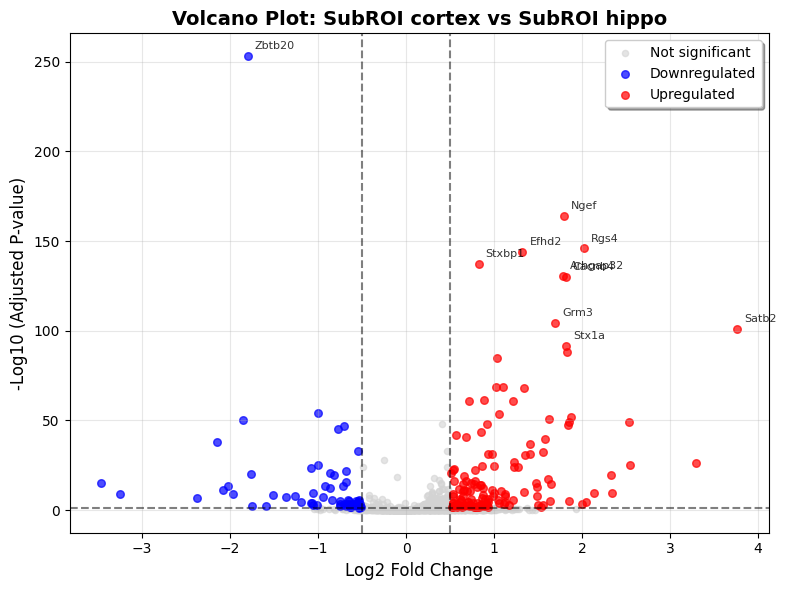

In [34]:
# Visualize DGE results
print(f"Creating volcano plot for {roi_group_1_name}...")

# Create the volcano plot
fig, ax = create_volcano_plot(
    adata_dge, 
    group_name=roi_group_1_name,
    key='rank_genes_dge',
    pval_threshold=0.05,
    logfc_threshold=0.5,
    title=f"Volcano Plot: {roi_group_1_name} vs {roi_group_2_name}",
    show_gene_labels=True,
    top_genes=10
)

plt.show()

In [35]:
# Displaying the DGE results as a DataFrame
dge_results_df = pd.DataFrame(adata_dge.uns['rank_genes_dge']['names'])[roi_group_1_name]
dge_scores_df = pd.DataFrame(adata_dge.uns['rank_genes_dge']['scores'])[roi_group_1_name]
dge_pvals_df = pd.DataFrame(adata_dge.uns['rank_genes_dge']['pvals_adj'])[roi_group_1_name]
dge_logfc_df = pd.DataFrame(adata_dge.uns['rank_genes_dge']['logfoldchanges'])[roi_group_1_name]

summary_df = pd.DataFrame({
    'gene': dge_results_df,
    'score': dge_scores_df,
    'pval_adj': dge_pvals_df,
    'log2fc': dge_logfc_df
})
print(f"\nTop differentially expressed genes for {roi_group_1_name} compared to {roi_group_2_name}:")
print(summary_df.head(20))


Top differentially expressed genes for SubROI cortex compared to SubROI hippo:
        gene      score       pval_adj    log2fc
0       Ngef  27.586956  7.658274e-165  1.793195
1       Rgs4  26.004335  1.415509e-146  2.016294
2      Efhd2  25.810921  1.604802e-144  1.321225
3     Stxbp1  25.191040  9.641952e-138  0.824999
4   Arhgap32  24.561882  5.166268e-131  1.785956
5     Cacnb4  24.537670  8.031763e-131  1.815390
6       Grm3  21.975723  5.899906e-105  1.693999
7      Satb2  21.650856  6.363919e-102  3.759176
8      Stx1a  20.559427   6.084150e-92  1.815999
9     Mpped1  20.203531   7.954156e-89  1.824884
10    Atp1a1  19.842541   1.022658e-85  1.027621
11    Cx3cl1  17.855463   1.935462e-69  1.023507
12    Snhg11  17.834837   2.599923e-69  1.098404
13    Cdk5r2  17.760513   9.147128e-69  1.333993
14    Sema7a  16.899036   2.743935e-62  0.881671
15      Grk2  16.819847   9.860307e-62  0.715104
16     Itpr1  16.790096   1.538007e-61  1.213856
17    Camk2g  15.750576   3.266830e-54

In [36]:
print("\n--- End of Script ---")


--- End of Script ---
